In [2]:
squares = [x**2 for x in range(1_000_000)]
palindromes_even = [int(str(x) + str(x)[::-1]) for x in range(1, 1_000_000)]
palindromes_odd = [int(str(x) + str(i) +  str(x)[::-1]) for i in range(10) for x in range(1, 1_000_000)]
palindromes = palindromes_even + palindromes_odd
pal_mult_23 = [x for x in palindromes if x % 23 == 0]

In [3]:
print(len(pal_mult_23))
print(pal_mult_23[:2])

478260
[1771, 4554]


In [4]:
N = 1000000000000
fibonacci = [0, 1]
while True:
    next_fib = fibonacci[-1] + fibonacci[-2]
    if next_fib > N:
        break
    fibonacci.append(next_fib)
len(fibonacci)


60

{'A': 'red',
 'B': 'blue',
 'C': 'pink',
 'D': 'brown',
 'E': 'lightgrey',
 'F': 'purple',
 'G': 'green',
 'H': 'cyan',
 'I': 'yellow',
 'J': 'grey',
 'K': 'magenta',
 'L': 'orange',
 'M': 'lightblue'}


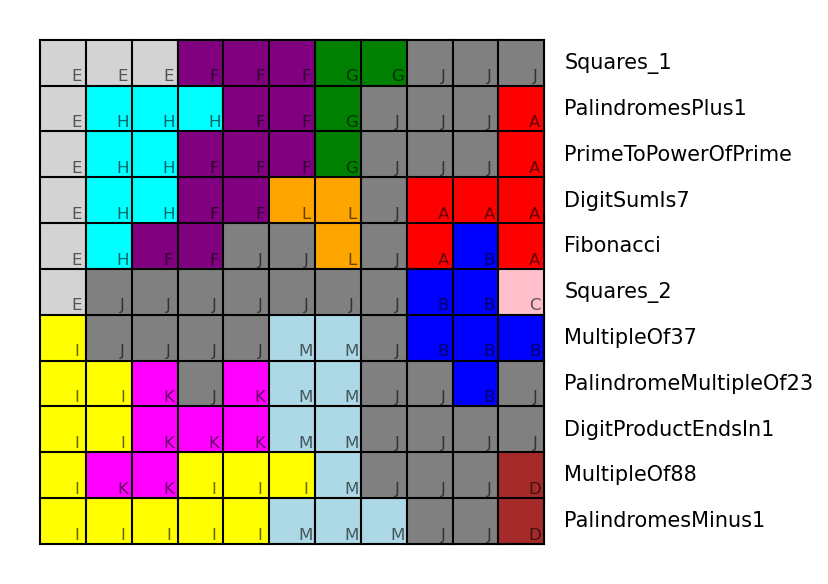

['EEEFFFGGJJJ',
 'EHHHFFGJJJA',
 'EHHFFFGJJJA',
 'EHHFFLLJAAA',
 'EHFFJJLJABA',
 'EJJJJJJJBBC',
 'IJJJJMMJBBB',
 'IIKJKMMJJBJ',
 'IIKKKMMJJJJ',
 'IKKIIIMJJJD',
 'IIIIIMMMJJD']

In [5]:
import enum
from pathlib import Path
from pprint import pprint
from matplotlib import pyplot as plt

from matplotlib.patches import Rectangle
import numpy as np

p = Path('input.txt')
assert p.exists()

with p.open() as file:
    MAP = [(l.strip()) for l in file.readlines()]

class Rows(enum.Enum):
    Squares_1 = 0
    PalindromesPlus1 = 1
    PrimeToPowerOfPrime = 2
    DigitSumIs7 = 3
    Fibonacci = 4
    Squares_2 = 5
    MultipleOf37 = 6
    PalindromeMultipleOf23 = 7
    DigitProductEndsIn1 = 8
    MultipleOf88 = 9
    PalindromesMinus1 = 10


KNOWN_VALUES = {}

# Define a color for each distinct character in the map
colors = [
    'lightgrey',
    'lightblue',
    'red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'grey', 'purple', 'orange', 'brown', 'pink',]
#random.shuffle(colors)
unique_characters = list(set(''.join(MAP)))
COLORS = dict(zip(unique_characters, colors))
pprint(COLORS)

def print_map():
    # Create a figure and axis
    plt.figure(dpi=150)
    ax: plt.Axes = plt.gca()
    # Draw the map
    w = 0.09
    for y, row in enumerate(MAP):
        for x, char in enumerate(row):
            coords = np.array([x, 10-y]).astype(float) / 11
            r = Rectangle(coords, w, w, color=COLORS[char])
            ax.add_patch(r)
            textcoords = coords + np.array([+0.8, +0.2]) / 11
            ax.text(*textcoords, char, color='black', ha='center', va='center', fontdict={'size': 8}, alpha=0.6)

    # Print lines
    for i in range(12):
        ax.plot([0, 1], [i/11, i/11], color='black', lw=1)
        ax.plot([i/11, i/11], [0, 1], color='black', lw=1)
    # Write names to the right
    for y, name in enumerate(Rows.__members__):
        ax.text(1.04, 1-(y+0.5)/11, name, color='black', ha='left', va='center')

    for (y,x), value in KNOWN_VALUES.items():
        coords = np.array([x, 10-y]).astype(float) / 11
        textcoords = coords + np.array([+0.5, +0.5]) / 11
        if value == "#":
            r = Rectangle(coords, w, w, color='black', alpha=1)
            ax.add_patch(r)
        else:
            ax.text(*textcoords, value, color='black', ha='right', va='center', fontdict={'size': 12})

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')
    # Remove the axes
    ax.axis('off')
    # Display the plot
    plt.show()    
    
def get_row_values(row: Rows):
    return MAP[row.value]

print_map() 
MAP

In [6]:
import functools
%pip install tqdm ipywidgets
from tqdm.notebook import tqdm

# To disable printing, set this to false.
ENABLE_PRINT = True

@functools.lru_cache
def count_generator(generator):
    return sum(1 for _ in generator())

def decorated_tqdm(total_number=None):
    def decorator(generator_func):
        total = (
            count_generator(generator_func) if total_number is None else total_number
        )
        @functools.wraps(generator_func)
        def wrapper(*args, do_print=True, **kwargs):
            if ENABLE_PRINT and do_print:
                fn_name = generator_func.__name__
                return tqdm(
                    generator_func(*args, **kwargs),
                    total=total,
                    desc=f"Generating {fn_name}",
                    unit="numbers",
                )
            else:
                return generator_func(*args, **kwargs)

        return wrapper

    return decorator


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:

MAX_N = 100_000_000_000
GENERATORS = {}

@decorated_tqdm()
def g_squares():
    # Output numbers must be at least 2 characters long
    x = 4
    n = x**2
    while n < MAX_N:
        yield n
        x += 1
        n = x**2


GENERATORS[Rows.Squares_1] = g_squares
GENERATORS[Rows.Squares_2] = g_squares


@decorated_tqdm()
def g_fibonnaci():
    a, b = 1, 1
    while a < 10:
        a, b = b, a + b
    while a < MAX_N:
        yield a
        a, b = b, a + b


GENERATORS[Rows.Fibonacci] = g_fibonnaci


@decorated_tqdm(total_number=MAX_N // 37)
def g_multiple_of_37():
    n = 37
    while n < MAX_N:
        yield n
        n += 37


GENERATORS[Rows.MultipleOf37] = g_multiple_of_37


@decorated_tqdm(total_number=MAX_N // 88)
def g_multiple_of_88():
    n = 88
    while n < MAX_N:
        yield n
        n += 88


GENERATORS[Rows.MultipleOf88] = g_multiple_of_88


@decorated_tqdm(total_number=10999989)
def g_palindromes():
    a, b = 1, 10
    while b < 1_000_0000:
        for i in range(a, b):
            si = str(i)
            sio = si[::-1]
            yield int(si + sio)

        for i in range(a, b):
            for j in range(10):
                si = str(i)
                if not a:
                    continue
                sio = si[::-1]
                yield int(f"{i}{j}{sio}")

        a = b
        b *= 10


@decorated_tqdm(total_number=10999989)
def g_palindromes_plus1():
    for paly in g_palindromes(do_print=False):
        yield paly + 1


GENERATORS[Rows.PalindromesPlus1] = g_palindromes_plus1


@decorated_tqdm(total_number=10999989)
def g_palindromes_minus1():
    for paly in g_palindromes(do_print=False):
        yield paly - 1


GENERATORS[Rows.PalindromesMinus1] = g_palindromes_minus1


@decorated_tqdm(total_number=478260)
def g_palindrome_multiple_of_23():
    for paly in g_palindromes(do_print=False):
        if paly % 23 != 0:
            continue
        yield paly

GENERATORS[Rows.PalindromeMultipleOf23] = g_palindrome_multiple_of_23

In [9]:
# Assert they are increasing
last = None
num_paly_generated = 0

def count_from_generator(generator):
    return sum(1 for _ in generator)

for paly in g_palindromes():
    assert last is None or paly > last, f"{paly=} {last=}"
    num_paly_generated += 1
    last = paly

print(f"{num_paly_generated=}")
print(f"{len(list(g_palindrome_multiple_of_23()))=}")


Generating g_palindromes:   0%|          | 0/10999989 [00:00<?, ?numbers/s]

num_paly_generated=10999989


Generating g_palindrome_multiple_of_23:   0%|          | 0/478260 [00:00<?, ?numbers/s]

len(list(g_palindrome_multiple_of_23()))=478260


In [17]:
# Digit mask

"""
We get a mask, say 'aab'
We want to return a number that matches the mask in its digits.
"""
from collections import defaultdict
from typing import Any, Generator, Iterable
from string import ascii_uppercase

# We want the i to spit out numbers that are increasing

def number_to_mask(n:int):
    """
    Returns a mask for the number
    Example: 1234 -> 'abcd', 1233 -> 'abcc'
    """
    chars = list(ascii_uppercase)
    mask_d = {}
    mask = ''
    for d in str(n):
        if d not in mask_d:
            mask_d[d] = chars.pop(0)
        mask += mask_d[d]
    return mask

def normlaize_mask(mask:str):
    """
    Returns a normalized mask
    Example: 'ca66' -> 'abcc'
    """
    mask_d = {}
    chars = list(ascii_uppercase)
    for m in mask:
        if m not in mask_d:
            mask_d[m] = chars.pop(0)
    return ''.join(mask_d[m] for m in mask)
    

def extract_masks_from_generator(i: Generator[int, Any, None]):
    " Returns all the masks that are present in the generator "
    P = defaultdict(list)
    for n in i:
        mask = number_to_mask(n)
        P[mask].append(n)
    return P

def number_matches_mask(i: Generator[int, Any, None], mask:str):
    for n in i:
        n = str(n)
        if len(n) < len(mask):
            continue
        if len(n) > len(mask):
            break

        # Try to construct a bijection between the mask and the digits
        M = {}
        for m, d in zip(mask, n):
            if m in '0123456789':
                # If we have a digit in the mask, it must match the digit in the number
                print("!!!! MASK NUMBER")
                if m != d:
                    break
            if m in M and M[m] != d or d in M and M[d] != m:
                break
            M[m] = d
            M[d] = m
        else:
            # If we reach the end of the loop without breaking, we have a match
            yield int(n)
    i.close()

for n in number_matches_mask(g_palindrome_multiple_of_23(), 'abcba'):
    print(n)


Generating g_palindrome_multiple_of_23:   0%|          | 0/478260 [00:00<?, ?numbers/s]

13731
16261
17871
20102
21712
25852
28382
37973
40204
41814
45954
52325
53935
56465
60306
61916
68586
72427
76567
79097
80408
84548
87078
92529
95059


In [18]:
# __

# ___
# X__
# __X

# ____
# ___X
# X___
# X__X

def get_possible_boxes():
    # Each space must be at least 2 apart.
    for i in range(2**11-1, -1 ,-1):
        a = f"{i:011b}"
        if "101" in a:
            continue
        if "11" in a:
            continue
        if a[1] == "1" or a[-2] == "1":
            continue
        yield i

def count_boxes():
    c = 0
    for _ in get_possible_boxes():
        c+=1
    return c

f"{count_boxes()=}"

'count_boxes()=54'

In [23]:
from pprint import pprint
from typing import List

import numpy as np

def get_borders(row_without_boxes: List[str], boxes_mask:int):
    assert len(row_without_boxes) == 11
    assert 0 <= boxes_mask < 2**11
    last = ""
    last_i = 0
    # Get ranges between boxes
    for i, field in enumerate(row_without_boxes):
        if (boxes_mask & 1<<(10-i)):
            # There is a box at this place
            if last:
                assert len(last) == i - last_i
                yield last, (last_i, i)
                last = ""
            last_i = i+1
        else:
            last += field
    if last:
        yield (last, (last_i, 11))

def generate_possible_box_number_configurations(row:str, generator_factory):
    # Track only possible options across all the boxes
    for boxes in get_possible_boxes():
        configuration = {}
        for mask, rng in get_borders(row, boxes):
            configuration[rng] = list(number_matches_mask(generator_factory(do_print=False), mask))
        if any(not v for v in configuration.values()):
            continue
        yield boxes, configuration


def get_fixed_points_from_configuratoin(update_configuration:dict):
    # Track only possible options across all the boxes
    configuration_fixpoints = {i: None for i in range(11)}
    for (start_pos, end_pos), candidate_values in update_configuration.items():
        for candidate_value in candidate_values:
            for character_index, character in zip(range(start_pos, end_pos), str(candidate_value)):
                if configuration_fixpoints[character_index] is None:
                    configuration_fixpoints[character_index] = set(character)
                else:
                    configuration_fixpoints[character_index].intersection_update(character)
    return {i: tuple(v)[0] for i, v in configuration_fixpoints.items() if v and len(v) == 1}

def attempt_row(row: Rows):
    print(row.name)
    total_possible_arrangements = 0

    # Track only possible options across all the boxes    
    character_fixpoint_votes = defaultdict(int)

    # Track boxes throughout all possible valid configurations. If there is a box in a place in all configurations, it must be there.
    box_fixpoints = None
    num_configs = 0
    if row not in GENERATORS:
        print("No generator for this row. Skipping.")
        return
    with tqdm(total=count_generator(GENERATORS[row])) as pbar:
        for boxes, config in generate_possible_box_number_configurations(get_row_values(row), GENERATORS[row]):
            num_configs += 1

            arrangements_in_config = np.prod([len(v) for v in config.values()])
            total_possible_arrangements += arrangements_in_config

            fixpoints = get_fixed_points_from_configuratoin(config)
            
            for k, v in fixpoints.items():
                character_fixpoint_votes[(k, v)] += 1

            if box_fixpoints is None:
                box_fixpoints = boxes
            else:
                box_fixpoints &= boxes
        
            pbar.update(1)
            pbar.set_postfix_str(f"{total_possible_arrangements=}")
        #print(f"\t{boxes:011b}")
        #pprint(config)
        
    print(f"{total_possible_arrangements=}")
    print(f"{num_configs=}")
    # print(f"{character_fixpoint_votes=}")
    known_row_values = {}
    for (character_index, character), fixpoint_occurances in character_fixpoint_votes.items():
        if fixpoint_occurances != num_configs:
            continue
        known_row_values[character_index] = character
        
    if box_fixpoints:
        print(f"{box_fixpoints=:011b}")
        for i in range(11):
            if box_fixpoints & 1<<i:
                known_row_values[i] = "#"
    
    print(f"{known_row_values=}")
    print()
    return {(row.value, k): v for k, v in known_row_values.items()}

worth_rows = [
    Rows.Squares_1,
    Rows.PalindromesPlus1,
    Rows.Fibonacci,
    Rows.Squares_2,
    Rows.PalindromeMultipleOf23,
    Rows.PalindromesMinus1,
    # Maybe precompute patterns?
    Rows.MultipleOf37, # Very slow ~5mins
    Rows.MultipleOf88, # Very slow ~5mins
]
worth_rows = list(range(11))
worth_rows.remove(Rows.MultipleOf37.value); worth_rows.append(Rows.MultipleOf37.value)
worth_rows.remove(Rows.MultipleOf88.value); worth_rows.append(Rows.MultipleOf88.value)

KNOWN_VALUES = {}
for row in worth_rows:
    if (new_knowledge := attempt_row(Rows(row))):
        KNOWN_VALUES.update(new_knowledge)

print_map()


Squares_1


  0%|          | 0/316224 [00:00<?, ?it/s]

total_possible_arrangements=6
num_configs=3
known_row_values={}

PalindromesPlus1


  0%|          | 0/10999989 [00:00<?, ?it/s]

total_possible_arrangements=30903
num_configs=18
known_row_values={}

PrimeToPowerOfPrime
No generator for this row. Skipping.
DigitSumIs7
No generator for this row. Skipping.
Fibonacci


  0%|          | 0/48 [00:00<?, ?it/s]

total_possible_arrangements=393
num_configs=10
known_row_values={}

Squares_2


  0%|          | 0/316224 [00:00<?, ?it/s]

total_possible_arrangements=24
num_configs=5
known_row_values={}

PalindromeMultipleOf23


  0%|          | 0/478260 [00:00<?, ?it/s]

total_possible_arrangements=0
num_configs=0
known_row_values={}

DigitProductEndsIn1
No generator for this row. Skipping.
PalindromesMinus1


Generating g_palindromes_minus1:   0%|          | 0/10999989 [00:00<?, ?numbers/s]

  0%|          | 0/10999989 [00:00<?, ?it/s]

total_possible_arrangements=1458
num_configs=4
box_fixpoints=00000010000
known_row_values={4: '#'}

MultipleOf37


Generating g_multiple_of_37:   0%|          | 0/2702702702 [00:00<?, ?numbers/s]

KeyboardInterrupt: 

In [ ]:
# program for weak compositions of 7
def compositions(n):
    if n == 1:
        return [[1]]
    else:
        return [[x] + y for x in range(n + 1) for y in compositions(n - x)] 
compositions(7)


RecursionError: maximum recursion depth exceeded in comparison